In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import numpy as np
import scvelo as scv
from tqdm.notebook import tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import sys
sys.path.append('../src/mousipy/')
from mousipy import *

# Visualizations

In [3]:
from matplotlib_venn import venn2, venn3

In [4]:
# load example data
mouse_data = scv.datasets.pancreas()
human_data = sc.datasets.pbmc3k()

In [5]:
human_data

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [6]:
mouse_data

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

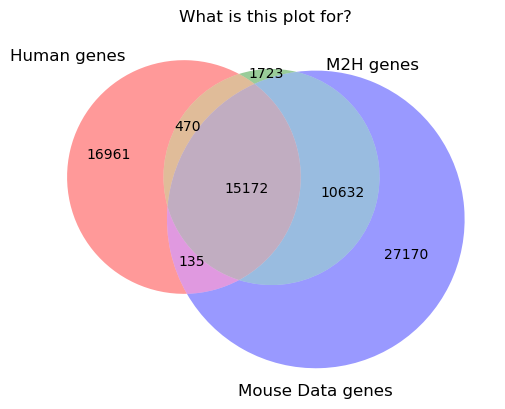

In [7]:
human_genes = set(human_data.var_names)
mouse_uppercased_genes = set([x.upper() for x in mouse_data.var_names])
mouse_conversion_genes = set([str(x).upper() for x in m2h_tab.index])

venn3([human_genes, mouse_uppercased_genes, mouse_conversion_genes], ('Human genes', 'M2H genes', 'Mouse Data genes'))
pl.title('What is this plot for?')
pl.show()


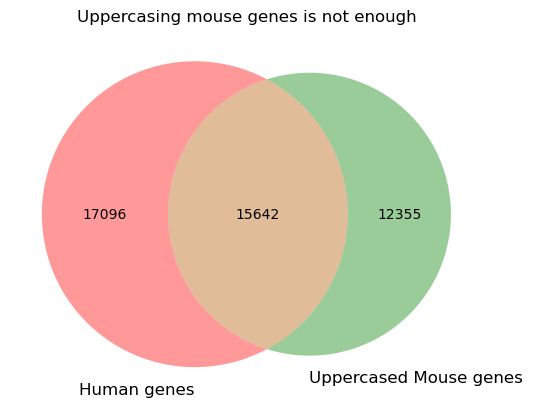

In [8]:
venn2([human_genes, mouse_uppercased_genes], ('Human genes', 'Uppercased Mouse genes'))
pl.title('Uppercasing mouse genes is not enough')
pl.show()

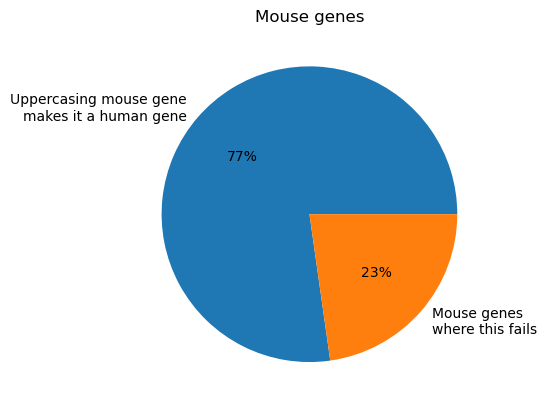

In [9]:
upperable_genes = [x for x in mouse_data.var_names if x.upper() in human_genes]  # mouse genes that are uppercase-able to an existing human gene
pl.pie([len(mouse_conversion_genes), len(upperable_genes)], 
       labels=['Uppercasing mouse gene\nmakes it a human gene', 'Mouse genes\nwhere this fails'], autopct='%.0f%%')
pl.title('Mouse genes')
pl.show()

In [10]:
m2h_direct, m2h_multiple, m2h_no_hit, m2h_no_index = check_orthologs(mouse_data.var_names, verbose=True)

100%|██████████| 27998/27998 [00:36<00:00, 775.62it/s]


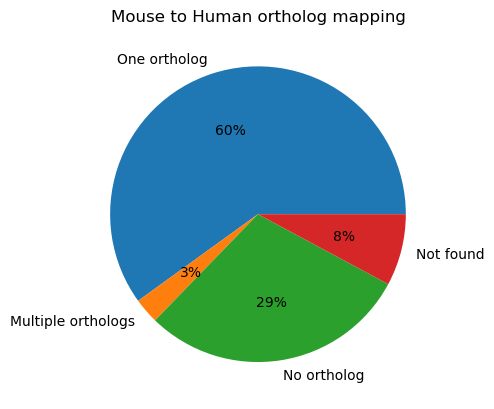

In [11]:
pl.pie([len(m2h_direct), len(m2h_multiple), len(m2h_no_hit), len(m2h_no_index)], 
       labels=['One ortholog', 'Multiple orthologs', 'No ortholog', 'Not found'], autopct='%.0f%%')
pl.title('Mouse to Human ortholog mapping')
pl.show()

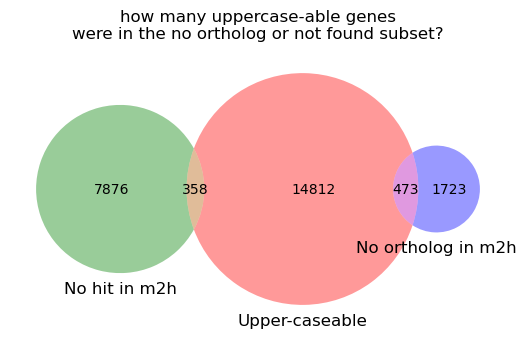

In [15]:
# how many uppercase-able genes were in the no ortholog or not found subset?

A = set(upperable_genes)
B = set(m2h_no_hit)
C = set(m2h_no_index)

venn3([A,B,C], ('Upper-caseable', 'No hit in m2h', 'No ortholog in m2h'))
pl.title('how many uppercase-able genes\nwere in the no ortholog or not found subset?')

pl.show()

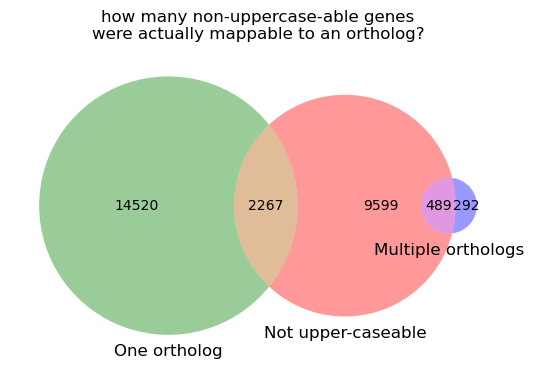

In [16]:
# how many non-uppercase-able genes were actually mappable to an ortholog?
non_upperable_genes = [x for x in mouse_data.var_names if x.upper() not in human_genes]

A = set(non_upperable_genes)
B = set(m2h_direct.keys())
C = set(m2h_multiple.keys())

venn3([A,B,C], ('Not upper-caseable', 'One ortholog', 'Multiple orthologs'))
pl.title('how many non-uppercase-able genes\nwere actually mappable to an ortholog?')
pl.show()

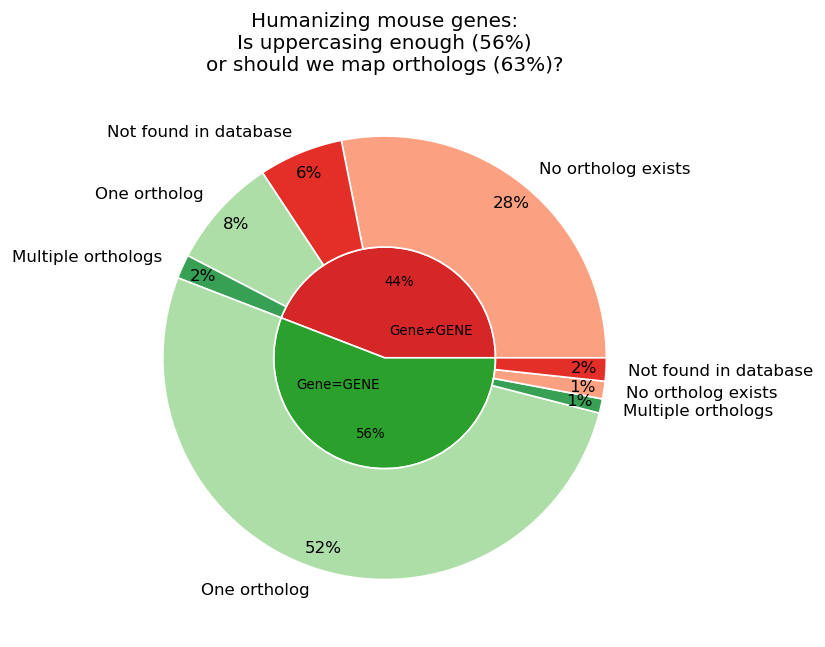

In [17]:
pl.figure(dpi=120, figsize=[6,6])
size=0.5
wedgeprops=dict(width=size, edgecolor='w')

from matplotlib.cm import get_cmap
Greens = get_cmap('Greens')
Reds = get_cmap('Reds')

# inner pie
pl.pie([len(non_upperable_genes), len(upperable_genes)], wedgeprops=wedgeprops, radius=1-size,
       autopct='%0.0f%%', pctdistance=.7,
       labels=['Gene≠GENE', 'Gene=GENE'], labeldistance=0.25, textprops={'fontsize': 8}, colors=['tab:red', 'tab:green'])

A1 = np.isin(list(m2h_direct.keys()), non_upperable_genes).sum()
A2 = np.isin(list(m2h_multiple.keys()), non_upperable_genes).sum()
A3 = np.isin(m2h_no_hit, non_upperable_genes).sum()
A4 = np.isin(m2h_no_index, non_upperable_genes).sum()

B1 = np.isin(list(m2h_direct.keys()), upperable_genes).sum()
B2 = np.isin(list(m2h_multiple.keys()), upperable_genes).sum()
B3 = np.isin(m2h_no_hit, upperable_genes).sum()
B4 = np.isin(m2h_no_index, upperable_genes).sum()

# outer pie
pl.pie([A3, A4, A1, A2, B1, B2, B3, B4], wedgeprops=wedgeprops, 
       labels=['No ortholog exists', 'Not found in database', 'One ortholog', 'Multiple orthologs', 'One ortholog', 'Multiple orthologs', 'No ortholog exists', 'Not found in database'],
       autopct='%0.0f%%', pctdistance=.9,
       colors=[Reds(1/3), Reds(2/3)] + [Greens(1/3), Greens(2/3)] *2 + [Reds(1/3), Reds(2/3)]
      )
pl.title('Humanizing mouse genes:\nIs uppercasing enough (56%)\nor should we map orthologs (63%)?')
pl.show()

In [18]:
# what's most interesting now are the genes that are not uppercase-able and but do have orthologs in the database
S = sorted([x for x in list(m2h_direct.keys()) if x in non_upperable_genes])

In [19]:
print(S)

['0610012G03Rik', '0610030E20Rik', '0610040J01Rik', '1110002E22Rik', '1110004F10Rik', '1110017D15Rik', '1110032A03Rik', '1110032F04Rik', '1110038F14Rik', '1110051M20Rik', '1110059E24Rik', '1110059G10Rik', '1110065P20Rik', '1190005I06Rik', '1500009L16Rik', '1520401A03Rik', '1600012H06Rik', '1600014C10Rik', '1700001C19Rik', '1700001L19Rik', '1700001O22Rik', '1700001P01Rik', '1700003E16Rik', '1700003F12Rik', '1700007K13Rik', '1700008O03Rik', '1700010I14Rik', '1700011L22Rik', '1700012B09Rik', '1700012P22Rik', '1700013F07Rik', '1700013H16Rik', '1700016C15Rik', '1700016H13Rik', '1700016K19Rik', '1700017B05Rik', '1700017N19Rik', '1700018B08Rik', '1700019D03Rik', '1700019N19Rik', '1700020L24Rik', '1700021F07Rik', '1700022I11Rik', '1700024G13Rik', '1700025G04Rik', '1700028K03Rik', '1700028P14Rik', '1700029H14Rik', '1700029I15Rik', '1700029J07Rik', '1700030J22Rik', '1700030K09Rik', '1700034J05Rik', '1700037C18Rik', '1700037H04Rik', '1700040F15Rik', '1700057G04Rik', '1700066B19Rik', '1700066M21Ri

In [20]:
# what's most interesting now are the genes that are not uppercase-able and but do have orthologs in the database
Sm = sorted([x for x in list(m2h_multiple.keys()) if x in non_upperable_genes])

In [21]:
print(Sm)

['0610010K14Rik', '1700011M02Rik', '4933412E24Rik', '7420426K07Rik', '8030474K03Rik', '9130401M01Rik', 'AA792892', 'AY761185', 'Acot3', 'Acot5', 'Acsm2', 'Adh1', 'Akp3', 'Apol10a', 'Apol10b', 'Apol11a', 'Apol11b', 'Apol7a', 'Apol7b', 'Apol7c', 'Apol7e', 'Apol8', 'Apol9a', 'Apol9b', 'Aqp12', 'Arf2', 'Arpin', 'Borcs7', 'C130073F10Rik', 'Ccl6', 'Ccl9', 'Cd200r2', 'Cd200r3', 'Cd200r4', 'Cd8b1', 'Ckmt1', 'Cyp2a4', 'Cyp2a5', 'Cyp3a13', 'Cyp4a10', 'Cyp4a30b', 'Cyp4a31', 'Cyp4a32', 'Defa17', 'Defa2', 'Defa20', 'Defa21', 'Defa22', 'Defa23', 'Defa24', 'Defa25', 'Defa26', 'Defb12', 'Defb13', 'Defb14', 'Defb15', 'Defb22', 'Defb34', 'Defb35', 'Defb43', 'Defb47', 'E330014E10Rik', 'E430018J23Rik', 'Ear1', 'Ear10', 'Ear14', 'Ear2', 'Ear6', 'Eef2kmt', 'Eif2s3x', 'F8a', 'Fam209', 'Fam90a1a', 'Fam90a1b', 'Fcgr1', 'Fcgr3', 'Fcgr4', 'Gh', 'Gimap3', 'Gm10024', 'Gm10100', 'Gm10142', 'Gm10256', 'Gm10272', 'Gm10334', 'Gm10352', 'Gm10767', 'Gm1140', 'Gm11555', 'Gm12789', 'Gm12790', 'Gm13040', 'Gm13043', 'Gm1305

In [23]:
'Cd8b1' in mouse_data.var_names

True

In [26]:
'Cd8b1' in Sm

True

In [27]:
'Cd8b1'.upper() in human_genes

False